## Optimizing queries of dbGaP data

A previous notebook in this folder (Data Connect - dbGaP 1.ipynb) explored differences in performance and data volume for FHIR, Data Connect and DRS. This notebook explores some advanced search options in FHIR to address the difference in comparison to Data Connect.

Set the location of your query log here.

In [1]:
query_log = "logs/fhir_comparison_log.json"

### Access data via Data Connect
As in the previous notebook we obtain the udn_phenotype_code data from Data Connect for comparison.


In [2]:
from data_connect_client import DataConnectClient
cl = DataConnectClient('http://localhost:8089/', debug=False, row_limit=100000,
                      query_log=query_log)

query_tags={'dataset':'udn_phenotype_code'}

In [3]:
df = cl.get_data('tutorial.scr_udn_v5.udn_phenotype_code', return_type='dataframe',
            query_tags=query_tags)
df

Retrieving the query
____Page1_______________
____Page2_______________
____Page3_______________
____Page4_______________
____Page5_______________
____Page6_______________
____Page7_______________
____Page8_______________
____Page9_______________
____Page10_______________
writing log
CPU times: user 123 ms, sys: 26.6 ms, total: 150 ms
Wall time: 3.25 s


,dbgap_subject_id,subject_id,hpo_phenotypes,hpo_observed_status
0,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0002020,no
1,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0002019,no
2,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0001763,no
3,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0000405,no
4,2181174,000d9998-d273-4946-88c3-f9946e107e42,HP:0000407,no
...,...,...,...,...
40315,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0002650,yes
40316,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0001251,yes
40317,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0002194,yes
40318,4297526,fff94748-b64d-4746-a7f1-463ebd6842e1,HP:0000252,yes


### Access the same data via FHIR
The dbgap_fhir module used here is a modified version of that in https://github.com/ncbi/DbGaP-FHIR-API-Docs/tree/production/jupyter

The module provides statistics about the amount of data retrieved and the time to do so.

In [22]:
from dbgap_fhir import DbGapFHIR
from dbgap_fhir import prettyprint

passport_path = '~/Downloads/task-specific-token.txt'
mf = DbGapFHIR('https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pilot/x1',
           passport=passport_path,
           #    ,api_key="~/.keys/ncbi_api_key.txt",
           debug=False,
           query_log=query_log)

### Optimization 1 - increasing resources per page
FHIR allows us to specify how many resources will be returned in a query. This effectively allows us to increase the number of records returned per page. Each page is a new request to the server. Returning fewer pages for a given query may increase performance. The default page size on the server used in these examples (and in the previous notebook) is 100. Here we use a \_count of 1000 to retrieve 1000 records at a time

In [3]:
conditions = mf.run_query("Condition?_count=1000",
                         query_tags=query_tags)

Total  Resources: 40320
Total  Bytes: 39075070
Total  Pages: 41
Time elapsed 131.2049 seconds
writing log
CPU times: user 873 ms, sys: 169 ms, total: 1.04 s
Wall time: 2min 11s


In [9]:
conditions = mf.run_query("Condition?_count=2000",
                         query_tags=query_tags)

Total  Resources: 40320
Total  Bytes: 39057923
Total  Pages: 21
Time elapsed 88.1209 seconds
writing log
CPU times: user 1.04 s, sys: 201 ms, total: 1.24 s
Wall time: 1min 28s


### Do the same for the Subject Phenotypes data

In this case the data is more complex

First from Data Connect

In [ ]:
query_tags['dataset'] = 'udn_subject_phenotypes'

In [21]:
obs_codes = ['phv00278118.v5.p2',
             'phv00278119.v5.p2',
             'phv00278120.v5.p2',
             'phv00278121.v5.p2',
             'phv00278122.v5.p2']

page_sizes = [1000, 2000, 5000]

for page_size in page_sizes:
    query_string = f"Observation?code={','.join(obs_codes)}&_count={page_size}"
    print(query_string)
    print()
    observations = mf.run_query(query_string,
                         query_tags=query_tags)

Observation?code=phv00278118.v5.p2,phv00278119.v5.p2,phv00278120.v5.p2,phv00278121.v5.p2,phv00278122.v5.p2&_count=100

Total  Resources: 25690
Total  Bytes: 24129396
Total  Pages: 257
Time elapsed 485.4767 seconds
writing log


### Compare the download times

The log specified below is previously obtained data. Substitute your own log if you have run the code above successfully.

In [2]:
fhir_query_log = 'data/fhir_comparison_log.json'

In [3]:
import json
import pandas as pd

with open(fhir_query_log) as f:
    query_stats = json.load(f)
    
query_stats_df = pd.DataFrame.from_dict(query_stats)
query_stats_df

,time,server,method,query,dataset,bytes,elapsed_secs,records,pages,requested_page_size,exclude_meta
0,2024-12-17T11:59:52.291038,https://cgc-ga4gh-api.sbgenomics.com,drs,/object/675c7dd64116992ffe2b84a8/access/s3,udn_phenotype_code,2414751,1.7896,NaN,NaN,NaN,NaN
1,2024-12-17T12:30:03.270167,https://cgc-ga4gh-api.sbgenomics.com,drs,/object/6759dfe8b1d2472def5713e5/access/s3,udn_subject_phenotypes,430048,1.6420,NaN,NaN,NaN,NaN
2,2024-12-10T09:06:08.998362,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,Condition?_count=1000,udn_phenotype_code,39075070,140.7841,40320.0,41.0,1000.0,NaN
3,2024-12-10T09:10:23.866075,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,Condition?_count=5000,udn_phenotype_code,39047624,66.6753,40320.0,9.0,5000.0,NaN
4,2024-12-10T09:16:05.872500,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,Condition?_count=2000,udn_phenotype_code,39057923,88.1209,40320.0,21.0,2000.0,NaN
5,2024-12-10T09:17:29.436502,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,"Observation?code=phv00278118.v5.p2,phv00278119...",udn_subject_phenotypes,23915219,41.4723,25690.0,6.0,5000.0,NaN
6,2024-12-10T09:19:01.156648,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,"Observation?code=phv00278118.v5.p2,phv00278119...",udn_subject_phenotypes,23921223,54.6031,25690.0,13.0,2000.0,NaN
7,2024-12-10T09:20:32.654874,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,"Observation?code=phv00278118.v5.p2,phv00278119...",udn_subject_phenotypes,23932357,82.1946,25690.0,26.0,1000.0,NaN
8,2024-12-10T09:26:08.434161,http://localhost:8089,data_connect,/table/tutorial.scr_udn_v5.udn_subject_phenoty...,udn_subject_phenotypes,1098533,3.0495,5138.0,2.0,NaN,NaN
9,2024-12-10T10:14:12.487009,https://dbgap-api.ncbi.nlm.nih.gov/fhir-jpa-pi...,fhir,"Observation?code=phv00278118.v5.p2,phv00278119...",udn_subject_phenotypes,24129396,485.4767,25690.0,257.0,100.0,NaN


### Create a more focussed dataframe for display and plotting
Only include relevant columns

Calculate size in MB for compactness.

Sort for display

In [4]:
# Calculate a data size in MBytes 
query_stats_df['MBytes'] = query_stats_df['bytes']/1024**2
plot_df = query_stats_df[["method", "dataset","requested_page_size", "pages", "exclude_meta", "elapsed_secs", "MBytes"]]

# Sorting by 'Rank' in ascending order and 'Age' in descending order
plot_df = plot_df.sort_values(by=['dataset', 'method', 'requested_page_size', 'exclude_meta'], na_position='first')

plot_df

,method,dataset,requested_page_size,pages,exclude_meta,elapsed_secs,MBytes
11,data_connect,udn_phenotype_code,NaN,4.0,NaN,3.2178,5.342960
0,drs,udn_phenotype_code,NaN,NaN,NaN,1.7896,2.302886
10,fhir,udn_phenotype_code,100.0,404.0,NaN,756.4901,37.560516
2,fhir,udn_phenotype_code,1000.0,41.0,NaN,140.7841,37.264891
4,fhir,udn_phenotype_code,2000.0,21.0,NaN,88.1209,37.248538
12,fhir,udn_phenotype_code,2000.0,21.0,True,94.8214,24.905493
3,fhir,udn_phenotype_code,5000.0,9.0,NaN,66.6753,37.238716
8,data_connect,udn_subject_phenotypes,NaN,2.0,NaN,3.0495,1.047643
1,drs,udn_subject_phenotypes,NaN,NaN,NaN,1.6420,0.410126
9,fhir,udn_subject_phenotypes,100.0,257.0,NaN,485.4767,23.011585


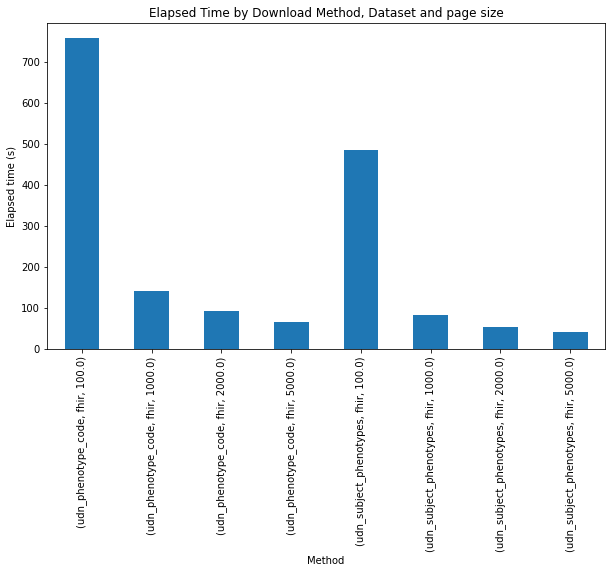

None

In [5]:
import matplotlib.pyplot as plt

# calculate elapsed time by dataset and method
df_groups = plot_df.groupby(['dataset','method','requested_page_size'])['elapsed_secs'].mean()

#create bar plot with custom aesthetics
df_groups.plot(kind='bar', title='Elapsed Time by Download Method, Dataset and page size',
               ylabel='Elapsed time (s)', xlabel='Method', figsize=(10, 6))

#rotate x-axis ticks 
plt.xticks(rotation=90)
display(plt.show())

/opt/anaconda3/envs/faspfhir/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


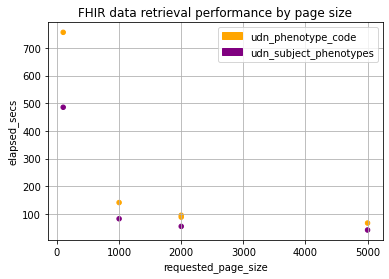

In [6]:
import matplotlib.patches as mpatches
colors = {'udn_phenotype_code': 'orange', 'udn_subject_phenotypes': 'purple'}
color_list = [colors[group] for group in plot_df['dataset']]
# Create legend handles, labels for each group and add legend to the plot
legend_handles = [
    mpatches.Patch(color=colors['udn_phenotype_code'], label='udn_phenotype_code'),
    mpatches.Patch(color=colors['udn_subject_phenotypes'], label='udn_subject_phenotypes') ]

ax = plot_df.plot.scatter(title='FHIR data retrieval performance by page size',
                          x='requested_page_size',
                     y='elapsed_secs',
                     c=color_list,
                     grid=True)

ax.legend(handles=legend_handles,
          loc='upper right')

plt.show()

### Discussion
Increasing the page size has a significant impact on performance. However, at higher page sizes responses may fail. A balance needs to reached between performance and possibly failed queries. This adds to the complexity of what a user needs to think about. 

### How has the increase page size affected the comparison with Data Connect  and DRS?

Given that high page sizes have a risk of failing, a practical page size of 2000 seems reasonable for the comparison with the other download methods. The first step is to create a reduced dataframe with only the Data Connect and DRS queries, and those from FHIR where the page size is 2000.


In [7]:
reduced_df = plot_df[(plot_df['method'] == 'data_connect') |
                     (plot_df['method'] == 'drs') |
                     (plot_df['requested_page_size'] == 2000.0)]
reduced_df

,method,dataset,requested_page_size,pages,exclude_meta,elapsed_secs,MBytes
11,data_connect,udn_phenotype_code,NaN,4.0,NaN,3.2178,5.342960
0,drs,udn_phenotype_code,NaN,NaN,NaN,1.7896,2.302886
4,fhir,udn_phenotype_code,2000.0,21.0,NaN,88.1209,37.248538
12,fhir,udn_phenotype_code,2000.0,21.0,True,94.8214,24.905493
8,data_connect,udn_subject_phenotypes,NaN,2.0,NaN,3.0495,1.047643
1,drs,udn_subject_phenotypes,NaN,NaN,NaN,1.6420,0.410126
6,fhir,udn_subject_phenotypes,2000.0,13.0,NaN,54.6031,22.813056


### Following the same method of plotting as in the previous notebook

In [22]:
import numpy as np
# The following sets up some variables to control the plotting of the data
dataset_labels = ['udn_phenotype_code', 'udn_subject_phenotypes']
n_methods = len(pd.unique(reduced_df['method']))
n_datasets = len(dataset_labels)
vline_x = n_methods - 0.5
x = np.arange( n_datasets/2, n_datasets*n_methods , n_methods)
x

array([1., 4.])

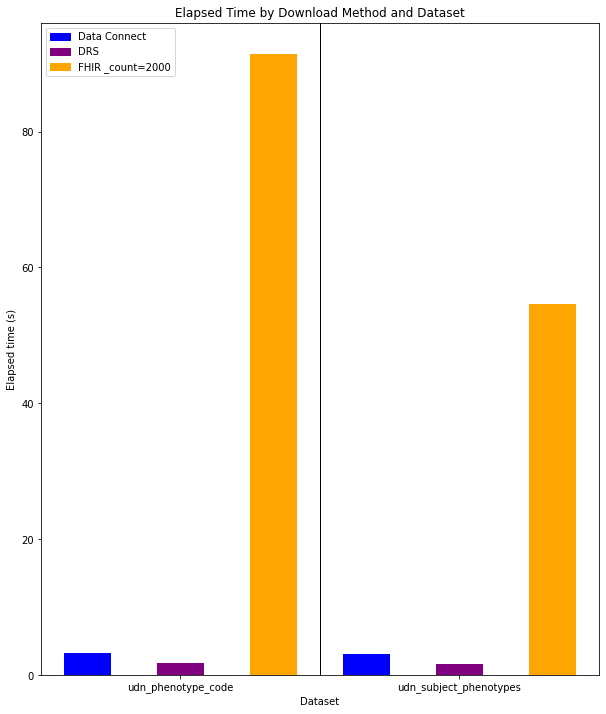

In [23]:
#calculate elapsed time by table and access method
df_groups = reduced_df.groupby(['dataset','method'])['elapsed_secs'].mean()

method_colors = {'data_connect': 'blue',
                 'drs': 'purple',
                 'fhir': 'orange'}
color_list = [method_colors[group[1]] for group in df_groups.keys()]# Create legend handles, labels for each group and add legend to the plot
legend_handles = [
    mpatches.Patch(color=method_colors['data_connect'], label='Data Connect'),
    mpatches.Patch(color=method_colors['drs'], label='DRS'),
    mpatches.Patch(color=method_colors['fhir'], label='FHIR _count=2000')
]

ax = df_groups.plot(kind='bar', title='Elapsed Time by Download Method and Dataset',
               ylabel='Elapsed time (s)', xlabel='Dataset', figsize=(10, 12),
              color=color_list)

ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
plt.xticks(rotation=0)
plt.axvline(x = vline_x, color='black', linewidth=1)
ax.legend(handles=legend_handles,
          loc='upper left')

plt.show()

### Discussion
Increasing the number of FHIR resources returned per page increases performance, but it is still relatively slow compared with Data Connect and DRS.

### Optimization 2 - exclude the meta tag from the FHIR response

As significant part of each FHIR resource is the meta tag. This contains metadata, generated by the server, about the resource. Depending on the server implementation additional housekeeping information may be provided here. For example, the dbGaP server uses the security tag in every resource.

The following syntax in a FHIR query allows the meta tag to be omitted in the response.

```
_elements:exclude=*.meta
```

In [ ]:
# Add a tag in the log to mark what we did
query_tags['exclude_meta'] = True

conditions = mf.run_query("Condition?_elements:exclude=*.meta&_count=2000",
                         query_tags=query_tags)

In [23]:
prettyprint(conditions[10])

{
   "resourceType": "Condition",
   "id": "cnd-2753986-278114-10668",
   "verificationStatus": {
      "coding": [
         {
            "system": "http://hl7.org/fhir/ValueSet/condition-ver-status",
            "code": "refuted"
         }
      ]
   },
   "code": {
      "coding": [
         {
            "system": "http://human-phenotype-ontology.org",
            "code": "HP:0000505"
         }
      ]
   },
   "subject": {
      "reference": "Patient/2753986"
   }
}


### Discussion
Excluding the meta tag decreases the size of the downloaded data but does not do anything to improve performance.

However, if the limiting factor is the volume of data in a request, then excluding the meta tag from the response may mean a larger number of records per page can be returned.

Experiment on the interplay between these factors has not yet been tried.

### Understanding the difference in performance

The data analysis below includes performance data when no passport is passed to dbGaP FHIR server. The FHIR server used in all these examples contains synthetic data - so access without a password is permissible. 

Two values for \_count were used. 

In [25]:
fhir_query_nopw_log = 'data/fhir_comparison_log_nopw.json'
with open(fhir_query_nopw_log) as f:
    query_stats = json.load(f)
    
query_stats_df = pd.DataFrame.from_dict(query_stats)
query_stats_df['MBytes'] = query_stats_df['bytes']/1024**2
plot_df = query_stats_df[["method", "dataset","requested_page_size", "pages", "elapsed_secs", "MBytes"]]

# Sorting by 'Rank' in ascending order and 'Age' in descending order
plot_df = plot_df.sort_values(by=['dataset', 'method', 'requested_page_size'], na_position='first')

plot_df

,method,dataset,requested_page_size,pages,elapsed_secs,MBytes
7,data_connect,udn_phenotype_code,NaN,4,3.2178,5.342960
4,fhir,udn_phenotype_code,100.0,404,756.4901,37.560516
0,fhir-1000,udn_phenotype_code,1000.0,41,140.7841,37.264891
8,fhir-1000-nopassport,udn_phenotype_code,1000.0,41,50.8658,37.264891
5,fhir-nopassport,udn_phenotype_code,0.0,404,72.0335,37.560506
2,data_connect,udn_subject_phenotypes,NaN,2,3.0495,1.047643
3,fhir,udn_subject_phenotypes,100.0,257,485.4767,23.011585
1,fhir-1000,udn_subject_phenotypes,1000.0,26,82.1946,22.823674
9,fhir-1000-nopassport,udn_subject_phenotypes,1000.0,26,30.8728,22.823674
6,fhir-nopassport,udn_subject_phenotypes,0.0,257,43.9872,23.011575


In [26]:
# The following sets up some variables to control the plotting of the data
dataset_labels = ['udn_phenotype_code', 'udn_subject_phenotypes']
n_methods = len(pd.unique(plot_df['method']))
n_datasets = len(dataset_labels)
vline_x = n_methods - 0.5
x = np.arange( n_methods/2, n_datasets*n_methods , n_methods)
x

array([2.5, 7.5])

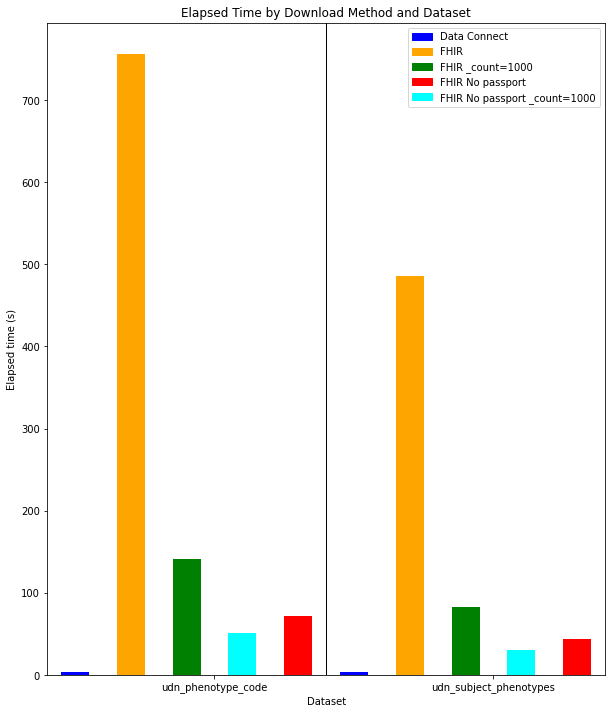

In [27]:
#calculate elapsed time by table and access method
df_groups = plot_df.groupby(['dataset','method'])['elapsed_secs'].mean()

method_colors = {'data_connect': 'blue', 
         'fhir': 'orange',
         'fhir-1000': 'green',
         'fhir-nopassport': 'red',
         'fhir-1000-nopassport': 'cyan'
                }
color_list = [method_colors[group[1]] for group in df_groups.keys()]# Create legend handles, labels for each group and add legend to the plot
legend_handles = [
    mpatches.Patch(color=method_colors['data_connect'], label='Data Connect'),
    mpatches.Patch(color=method_colors['fhir'], label='FHIR'),
    mpatches.Patch(color=method_colors['fhir-1000'], label='FHIR _count=1000'),
    mpatches.Patch(color=method_colors['fhir-nopassport'], label='FHIR No passport'),
    mpatches.Patch(color=method_colors['fhir-1000-nopassport'], label='FHIR No passport _count=1000')
]

ax = df_groups.plot(kind='bar', title='Elapsed Time by Download Method and Dataset',
               ylabel='Elapsed time (s)', xlabel='Dataset', figsize=(10, 12),
              color=color_list)

ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
plt.xticks(rotation=0)
plt.axvline(x = vline_x, color='black', linewidth=1)
ax.legend(handles=legend_handles,
          loc='upper right')

plt.show()

### Discussion

When no passport is passed to the dbGaP FHIR server it seems the server is not calling the clearing house.

Regarding the slower performance; it seems the clearing house is being called for every page and this adds a significant overhead.

In the Data Connect workflow the clearing house is only be called once per query.

For subsequent pages communication with the Data Connect and trino servers would take place over an encrypted connection (https). The "next page" urls which provide access to the data are therefore passed securely.

For DRS the clearing house is obtained only once to obtain the url used to download the file.